<a href="https://colab.research.google.com/github/akipips/kaggle/blob/master/house_price/EDA/housing_prices_lgbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Housing Prices - LGBM

Housing Prices Advanced Regression - submission version
* Data Exploration
* Feature Engineering
* Clean Code
* LGBM

元コード：[Housing Prices - LGBM](https://www.kaggle.com/bryanafreeman/housing-prices-lgbm)

[Data analysis worksheet](https://docs.google.com/spreadsheets/d/1AGyWYMi1CrMCk2jZ8NrVu7g9kjB_ovynVSNddyK904E/edit?usp=sharing)

Credit to [Pedro Marcelino's](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python) notebook on data exploration.

In [95]:
import pdb
import pickle
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from scipy import stats
from scipy.special import boxcox1p
from scipy.stats import norm, skew
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.svm import SVR
from sklearn_pandas import DataFrameMapper
from operator import itemgetter
import lightgbm as lgb


import os

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

# Read the CSV
train_csv_path = '/content/train.csv'
test_csv_path = '/content/test.csv'
train_set = pd.read_csv(train_csv_path)
test_set = pd.read_csv(test_csv_path)

# Keep original data clean
train_data = train_set.copy()
test_data = test_set.copy()
train_ids = train_data['Id'].copy()
test_ids = test_data['Id'].copy()
print('Test data original columns: {}'.format(train_data.columns.to_list()))

Test data original columns: ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'Screen

In [96]:
print('Train data original shape: {}'.format(train_data.shape))
print('Test data original shape: {}'.format(test_data.shape))

Train data original shape: (1460, 81)
Test data original shape: (1459, 80)


In [97]:
train_data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Explore the Data

### Sale Price

In [98]:
train_data['SalePrice'].describe()

count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64

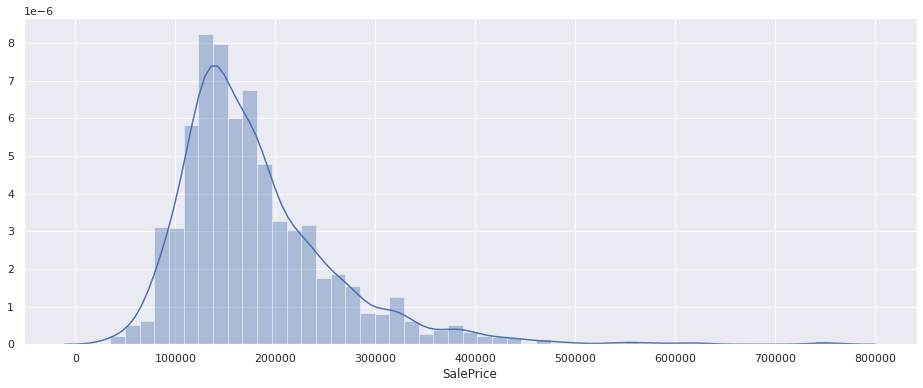

In [99]:
plt.figure(figsize=(16, 6))
sns.distplot(train_data['SalePrice']);

* Positive skewed distribution
* Peakedness

### Mean Sale Price by Neighborhood

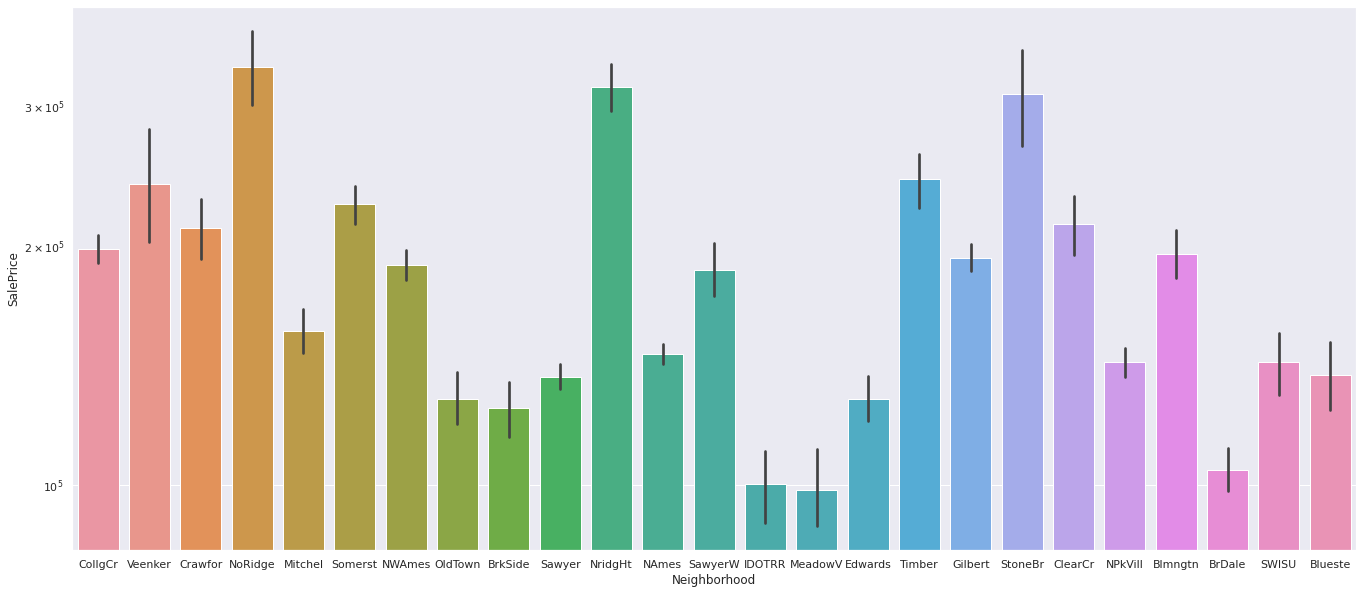

In [100]:
fig, ax = plt.subplots(figsize=(23,10))
ax.set(yscale="log")
sns.barplot(x="Neighborhood", y="SalePrice", data=train_data, estimator=np.mean)
plt.show()



#### Sale Price and Living Area

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


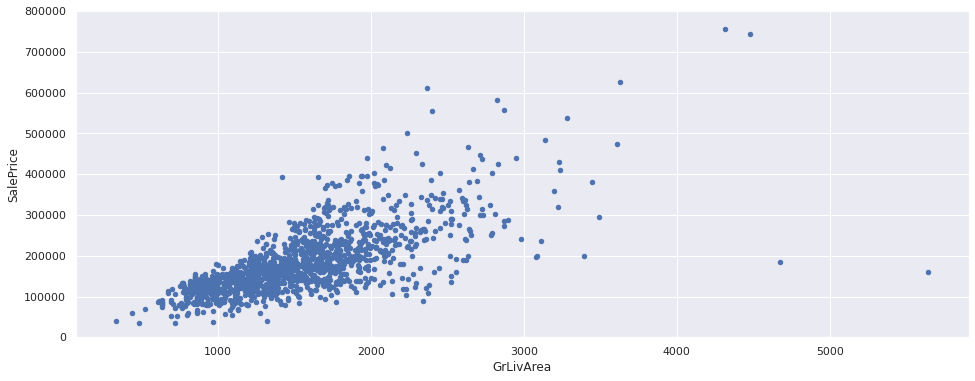

In [101]:
var = 'GrLivArea'
data = pd.concat([train_data['SalePrice'], train_data[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', figsize=(16, 6), ylim=(0,800000));

* Linear relationship with living area

*リビングエリアとの線形関係

#### Sale Price and Overall Quality

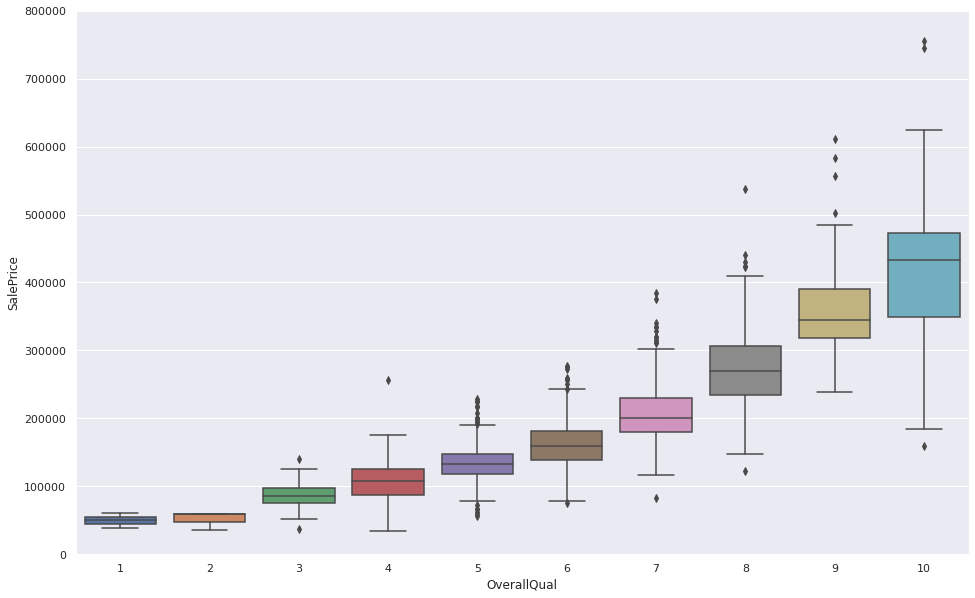

In [102]:
var = 'OverallQual'
data = pd.concat([train_data['SalePrice'], train_data[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 10))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

#### Sale Price and Year Built

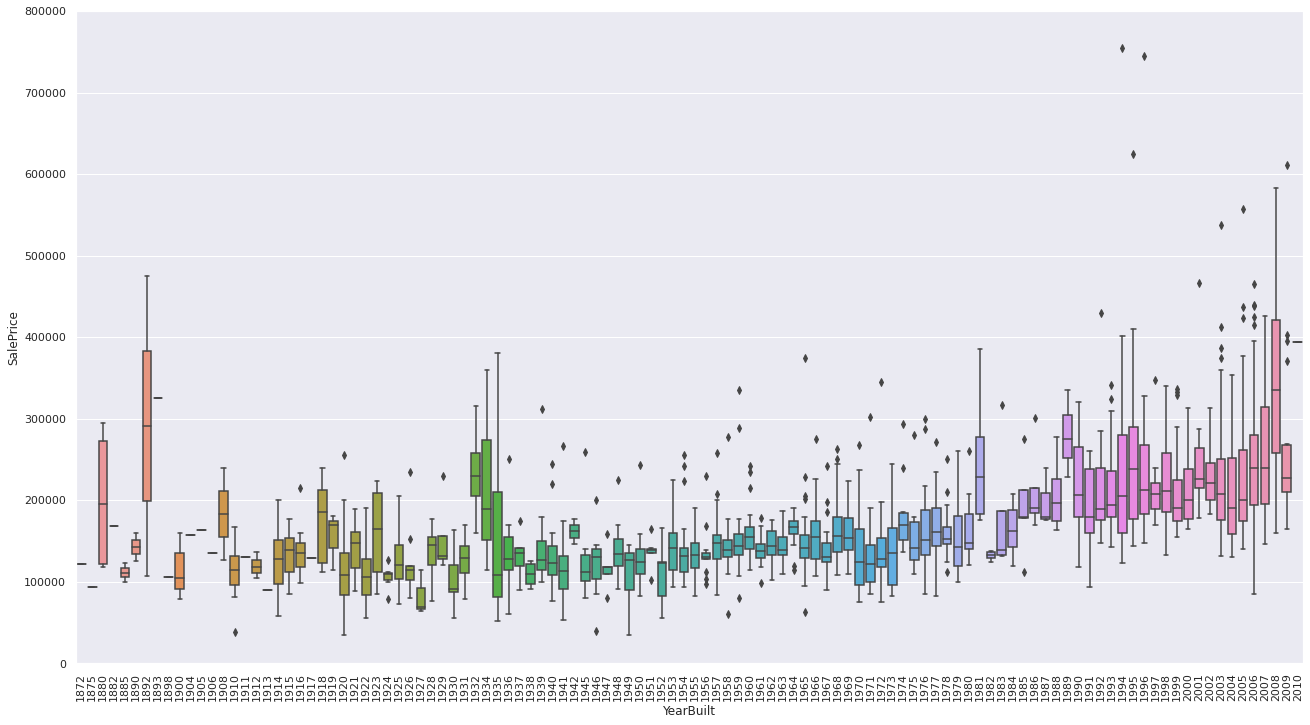

In [103]:
var = 'YearBuilt'
data = pd.concat([train_data['SalePrice'], train_data[var]], axis=1)
f, ax = plt.subplots(figsize=(22, 12))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

Conclusions:
* 'GrLivArea' and 'TotalBsmtSF' linearly related with 'SalePrice' 
* Both relationships are positive
* 'OverallQual' and 'YearBuilt' also related to 'SalePrice'

### Correlations

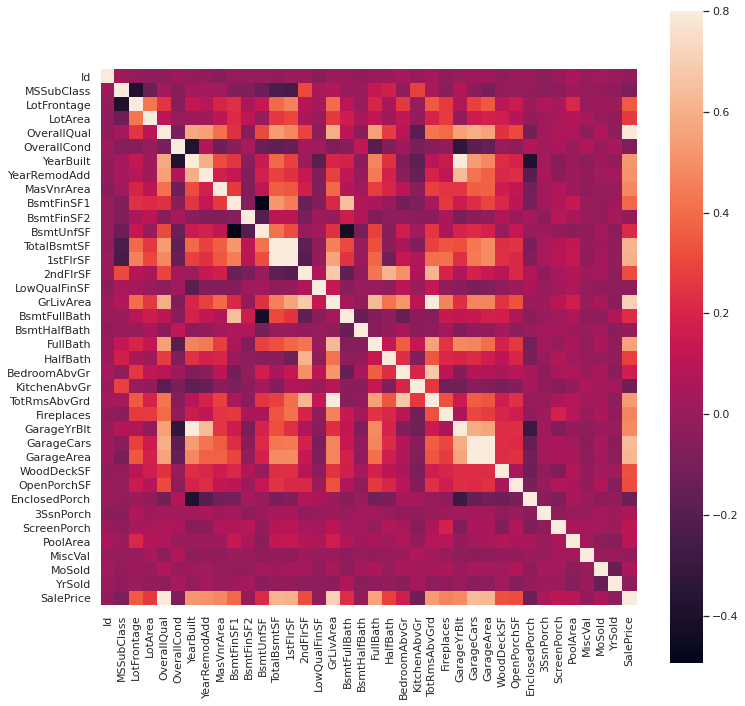

In [104]:
corrs_matrix = train_data.corr()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrs_matrix, vmax=.8, square=True);



### Scatterplot with Correlated Variables

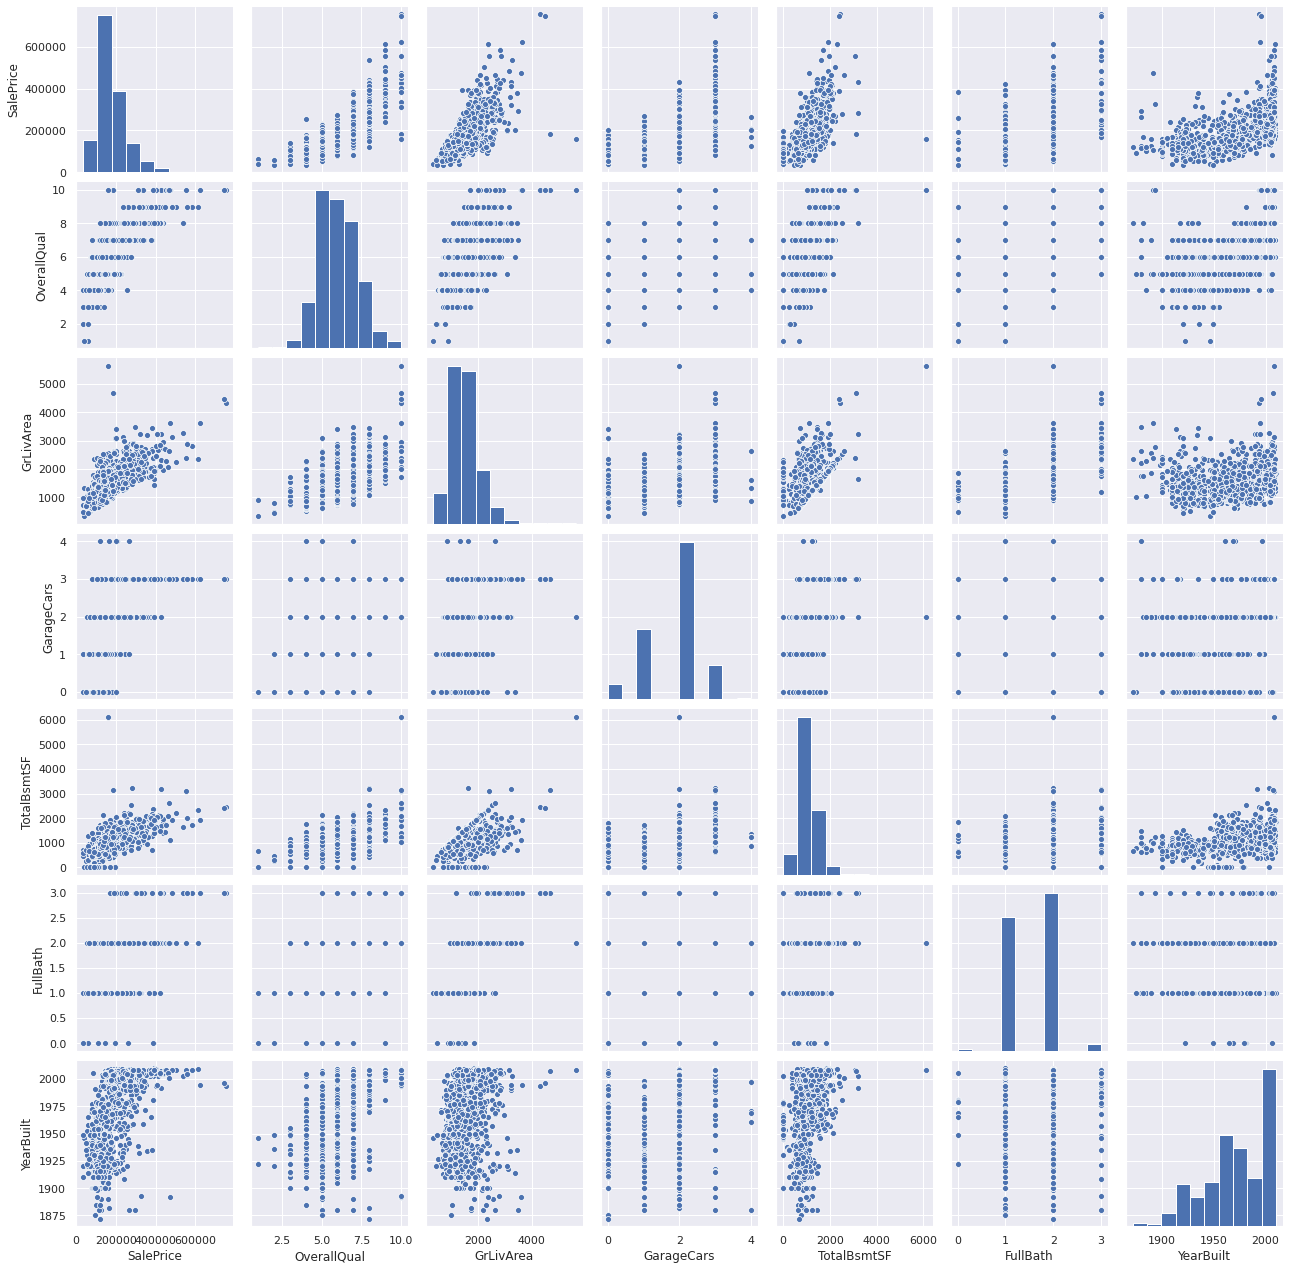

In [105]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train_data[cols], size = 2.5)
plt.show();

### Missing Data

In [106]:
total = train_data.isnull().sum().sort_values(ascending=False)
percent = (train_data.isnull().sum()/train_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995
MiscFeature,1406,0.963
Alley,1369,0.938
Fence,1179,0.808
FireplaceQu,690,0.473
LotFrontage,259,0.177
GarageCond,81,0.055
GarageType,81,0.055
GarageYrBlt,81,0.055
GarageFinish,81,0.055


### Scale Sales Data

In [107]:
saleprice_scaled = StandardScaler().fit_transform(train_data['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('Low range of distribution:')
print(low_range)
print('\nHigh range of the distribution:')
print(high_range)

Low range of distribution:
[[-1.83870376]
 [-1.83352844]
 [-1.80092766]
 [-1.78329881]
 [-1.77448439]
 [-1.62337999]
 [-1.61708398]
 [-1.58560389]
 [-1.58560389]
 [-1.5731    ]]

High range of the distribution:
[[3.82897043]
 [4.04098249]
 [4.49634819]
 [4.71041276]
 [4.73032076]
 [5.06214602]
 [5.42383959]
 [5.59185509]
 [7.10289909]
 [7.22881942]]


### Bivariate Analysis

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


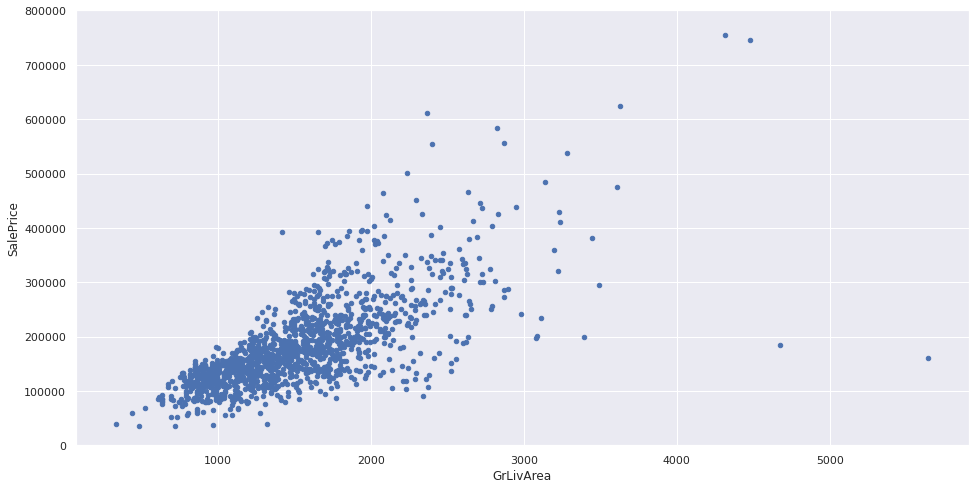

In [108]:
var = 'GrLivArea'
data = pd.concat([train_data['SalePrice'], train_data[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000), figsize=(16, 8));

The two living are points around 4600 and 5600 don't seem to be obeying the rules. I'm going to delete them

In [109]:
train_data.sort_values(by = 'GrLivArea', ascending = False)[:2]
train_data = train_data.drop(train_data[train_data['Id'] == 1299].index)
train_data = train_data.drop(train_data[train_data['Id'] == 524].index)

### Fixing Distributions

#### Sales

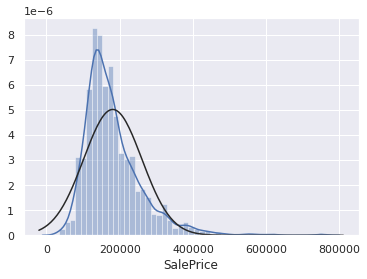

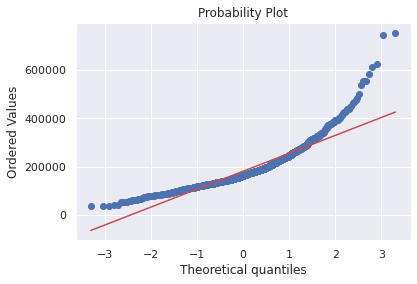

In [110]:
sns.distplot(train_data['SalePrice'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(train_data['SalePrice'], plot=plt)

#### Apply Log Transformation

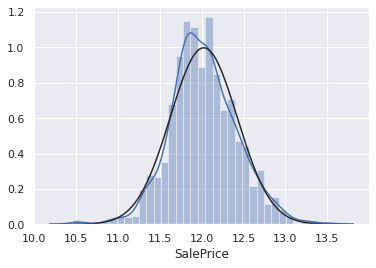

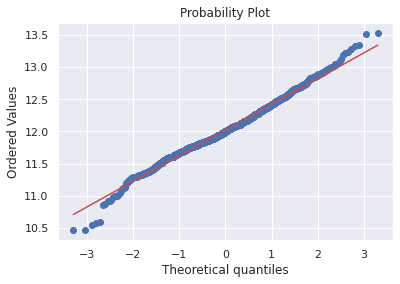

In [111]:
train_data['SalePrice'] = np.log(train_data['SalePrice'])
sns.distplot(train_data['SalePrice'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(train_data['SalePrice'], plot=plt)

#### Living Area

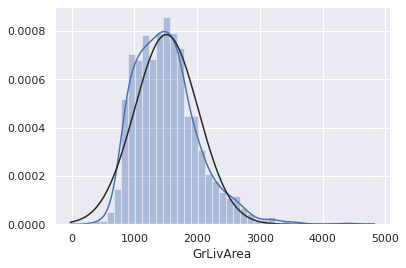

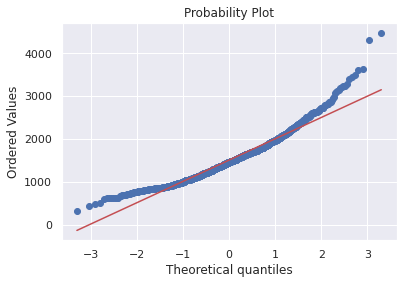

In [112]:
sns.distplot(train_data['GrLivArea'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(train_data['GrLivArea'], plot=plt)

#### Apply Log Transform

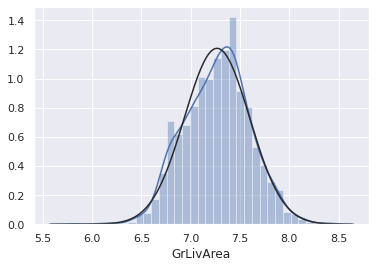

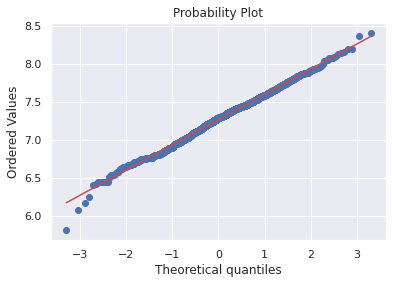

In [113]:
train_data['GrLivArea'] = np.log(train_data['GrLivArea'])
sns.distplot(train_data['GrLivArea'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(train_data['GrLivArea'], plot=plt)

### Total Basement Square Footage

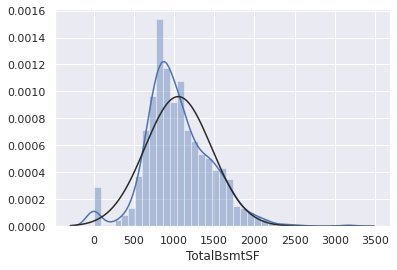

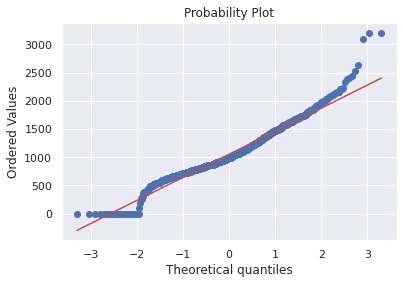

In [114]:
sns.distplot(train_data['TotalBsmtSF'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(train_data['TotalBsmtSF'], plot=plt)

なんか見たことありました

## Prepare Data for Training

In [115]:
# Revert to clean training data
train_data = train_set.copy()
train_index = train_data.shape[0]
test_index = test_data.shape[0]
target = train_data.SalePrice.values
all_data = pd.concat((train_data, test_data)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
all_data.shape

(2919, 80)

### Missing Values

In [116]:
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')
all_data['Alley'] = all_data['Alley'].fillna('None')
all_data['Fence'] = all_data['Fence'].fillna('None')
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('FireplaceQu')
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data['MasVnrType'] = all_data['MasVnrType'].fillna('None')
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")#最頻値で補充

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

### Numeric Transformations

In [117]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)#strに型を変換

### Label Encoding

In [118]:
print(all_data['Street'].describe())

columns = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for col in columns:
    encoder = LabelEncoder() 
    encoder.fit(list(all_data[col].values)) 
    all_data[col] = encoder.transform(list(all_data[col].values))
    
all_data.shape
print(all_data['Street'].describe())

count     2919
unique       2
top       Pave
freq      2907
Name: Street, dtype: object
count   2919.000
mean       0.996
std        0.064
min        0.000
25%        1.000
50%        1.000
75%        1.000
max        1.000
Name: Street, dtype: float64


### New Features

In [119]:
sale_year = np.max(all_data['YrSold'])
print(sale_year)
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']#TotalSF=家の総スペース
all_data.shape

4


(2919, 81)

### Skew

In [120]:
num_features = all_data.dtypes[all_data.dtypes != 'object'].index
print(num_features)
skewed_features = all_data[num_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_features})
skewness.head(10)

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC',
       'CentralAir', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscVal', 'MoSold',
       'YrSold', 'TotalSF'],
      dtype='object')


,Skew
MiscVal,21.947
PoolArea,16.898
LotArea,12.822
LowQualFinSF,12.089
3SsnPorch,11.376
LandSlope,4.975
KitchenAbvGr,4.302
BsmtFinSF2,4.146
EnclosedPorch,4.004
ScreenPorch,3.947


##Box-Cox transformationで非正規分布のデータを正規分布に近づける

Box-Cox Transormationは次の式による変換。$λ=0$のときは$log(x)$

$$
x'=\frac{x^λ-1}{λ}
$$

λが1より大きい場合は小さな値の間隔が圧縮され、小さい場合は大きな値の間隔が圧縮されるように変換される。

これによって左右非対称な分布を対称(skew=0)な正規分布に近づけることができる。

[引用元](https://www.sambaiz.net/article/218/)



In [121]:
skewness = skewness[abs(skewness) > 0.75]
print('{} skewed features to transform'.format(skewness.shape[0]))

from scipy.special import boxcox1p#boxcox変換用の関数をインポート
skewed_features = skewness.index
print(skewness.index)
lam = 0.15#λ
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
all_data = pd.get_dummies(all_data)
all_data.shape

60 skewed features to transform
Index(['MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', '3SsnPorch',
       'LandSlope', 'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch',
       'ScreenPorch', 'BsmtHalfBath', 'MasVnrArea', 'OpenPorchSF',
       'WoodDeckSF', 'TotalSF', 'LotFrontage', '1stFlrSF', 'BsmtFinSF1',
       'GrLivArea', 'TotalBsmtSF', 'BsmtUnfSF', '2ndFlrSF', 'TotRmsAbvGrd',
       'Fireplaces', 'HalfBath', 'FireplaceQu', 'BsmtFullBath', 'OverallCond',
       'HeatingQC', 'BedroomAbvGr', 'GarageArea', 'OverallQual', 'FullBath',
       'MSSubClass', 'YrSold', 'BsmtFinType1', 'Id', 'GarageCars',
       'YearRemodAdd', 'BsmtQual', 'YearBuilt', 'GarageFinish', 'LotShape',
       'MoSold', 'Alley', 'BsmtExposure', 'KitchenQual', 'ExterQual', 'Fence',
       'ExterCond', 'BsmtCond', 'PavedDrive', 'BsmtFinType2', 'GarageQual',
       'CentralAir', 'GarageCond', 'GarageYrBlt', 'Functional', 'Street',
       'PoolQC'],
      dtype='object')


(2919, 224)

In [122]:
train_data = all_data[:train_index]
test_data = all_data[train_index:]

## Train The Models

### Train - Validation Split

In [123]:
X_train, X_val, y_train, y_val = train_test_split(
    train_data, target, test_size=0.20, random_state=42)

### Model

In [124]:
model = lgb.LGBMRegressor(objective='regression',
                         num_leaves=5,
                         learning_rate=0.05,
                         n_estimators=720,
                         max_bin = 55,
                         bagging_fraction = 0.8,
                         bagging_freq = 5,
                         feature_fraction = 0.2319,
                         feature_fraction_seed=9,
                         bagging_seed=9,
                         min_data_in_leaf =6,
                         min_sum_hessian_in_leaf = 11)

### Validation Function

In [125]:
n_folds = 5

y_train_scaled = np.log1p(y_train)#底をeとするa+1の対数
y_val_scaled = np.log1p(y_val)

def rmse_cv(model, X, y):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)#Returns the number of splitting iterations in the cross-validator
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5))#二乗平均平方根誤差
    return rmse

### Train Scores

In [126]:
X = X_train
y = y_train_scaled

score = rmse_cv(model, X, y)
print("Model score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

Model score: 0.1213 (0.0124)



## Validate Model

In [127]:
def rmse_cv_val(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5))
    return rmse

In [128]:
X = X_val
y = y_val_scaled


score = rmse_cv_val(model, X, y)
print("Validation score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Validation score: 0.1623 (0.0279)



## Create the Submission

### Final Fit

In [129]:
X = X_train
y = y_train_scaled
model.fit(X, y)

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.2319, feature_fraction_seed=9,
              importance_type='split', learning_rate=0.05, max_bin=55,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=6, min_split_gain=0.0,
              min_sum_hessian_in_leaf=11, n_estimators=720, n_jobs=-1,
              num_leaves=5, objective='regression', random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

### Create Output

In [ ]:
X = test_data
predictions = np.exp(model.predict(X))
result=pd.DataFrame({'Id':test_ids, 'SalePrice':predictions})
result.to_csv('/kaggle/working/submission.csv',index=False)
print('done')

done
